In [4]:
import csv

def parse_txt(filename, oriented=True):
    """
    Parse data from txt file into dict python type.
    JSON serializable.
    """
    data = {}
    with open(filename) as file:
        
        line = file.readline()
        while line:
            
            # skip comments
            if line[0] == '#':
                line = file.readline()
                continue
            
            parent, child = line.split()
            
            parent = int(parent)
            child = int(child)
            
            # rows in data file can be duplicated
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'degree': 1,
                }
                
            if oriented:
                if child not in data:
                    data[child] = { 
                    'linked': [],
                    'degree': 0,
                }
                
            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'degree': 1,
                    }

            line = file.readline()

    return data

def parse_csv(filename, oriented=True):
    data = {}
    
    with open(filename) as file:
        reader = csv.reader(file)
        next(reader)
        
        for row in reader:
            
            parent = int(row[0])
            child = int(row[1])
            
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            if oriented:
                if child not in data:
                    data[child] = { 
                    'linked': [],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }
                    
    return data

def parse(filename, oriented=True):
    if filename.split('.')[-1] == 'txt':
        return parse_txt(filename, oriented)
    elif filename.split('.')[-1] == 'csv':
        return parse_csv(filename, oriented)

In [17]:
FILENAME = 'email-Eu-core.txt'
#FILENAME = 'test.txt'
ORIENTED = True

In [18]:
data = parse(FILENAME, ORIENTED)
print(data)

{0: {'linked': [1, 316, 146, 268, 581, 221, 18, 734, 178, 380, 0, 459, 215, 250, 148, 73, 498, 226, 101, 218, 377, 17, 74, 177, 248, 103, 560, 309, 88, 5, 297, 313, 223, 238, 368, 266, 222, 283, 6, 64, 166], 'degree': 41}, 1: {'linked': [1], 'degree': 1}, 2: {'linked': [3, 4, 195, 305, 2, 412, 102, 194, 55, 252, 13, 63, 192, 586, 408, 138, 434, 6, 281, 193, 174, 285, 137, 323, 211, 58, 238, 520, 481, 665, 59, 208, 5, 506, 516, 517, 160, 286, 57, 132, 409, 411, 587, 140, 96, 64, 809, 826, 158, 738, 832, 273, 803, 845, 571, 89, 54, 300, 489, 612, 249, 865, 283, 107, 880, 698, 899, 86, 886, 162, 546, 812, 859, 308, 131, 56, 333, 971, 271, 990, 685, 405, 896, 1001], 'degree': 84}, 3: {'linked': [63, 3, 2, 4, 408, 58, 174, 192, 303, 56, 286, 59, 236, 665, 175, 412, 195, 520, 411, 137, 158, 194, 239, 107, 571, 859, 89, 62, 601, 57, 812, 102, 208, 832, 183, 256, 434, 685, 193, 323, 971, 845, 6, 252, 271, 281, 880, 473, 405, 210, 128, 371, 211, 46, 990, 1001], 'degree': 56}, 4: {'linked': [2, 

In [19]:
def count_vertices(graph):
    return len(graph)

def count_edges(graph,oriented = False):
    edges = 0
    for item in graph.values():
        edges += item['degree']
    if oriented:
        return edges
    return edges / 2

vertices = count_vertices(data)
edges = count_edges(data,ORIENTED)
complete_graph_edges = vertices * (vertices - 1) / 2

print(f'Number of vertices in {FILENAME}: {vertices}')
print(f'Number of edges in {FILENAME}: {edges}')
print(f'Number of edges in complete graph: {complete_graph_edges}')
print(f'Density: {edges / complete_graph_edges}')

Number of vertices in email-Eu-core.txt: 1005
Number of edges in email-Eu-core.txt: 25571
Number of edges in complete graph: 504510.0
Density: 0.050684822897464864


In [20]:
def dfs(graph, start, visited=None):
    if visited is None:
        visited = set()
    visited.add(start)
    for next in set(graph[start]["linked"]) - visited:
        dfs(graph, next, visited)
    return visited

def get_weak_connectivity_components(graph):
    weak_connectivity_components = []
    max_component = []
    nodes = []
    for item in graph.keys():
        if item not in nodes:
            component = dfs(graph,item)
            for key in component:
                nodes.append(key)
            if len(component) > len(max_component):
                max_component = component
            weak_connectivity_components.append(component)
                
    return (weak_connectivity_components, max_component)


def make_unoriented(graph):
    result = dict.fromkeys(graph.keys(),{})
    for key in graph.keys():
        result[key] = graph[key]
    for key in result.keys():
        for vertex in graph[key]['linked']:
            if key not in result[vertex]['linked'] and key != vertex:
                result[vertex]['linked'].append(key)
                result[vertex]['degree'] += 1
    return result
    
    
[weak_connectivity_components,max_weak_connectivity_component] = get_weak_connectivity_components(make_unoriented(data))
max_weak_connectivity_component_size = len(max_weak_connectivity_component)
print(weak_connectivity_components)
print(max_weak_connectivity_component_size)
print(f'Number of weak connectivity components in {FILENAME}: {len(weak_connectivity_components)}')
print(f'Proportion of vertices in max weak connectivity component: {max_weak_connectivity_component_size/vertices}')

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [19]:
from collections import defaultdict

class Graph:
   
    def __init__(self,vertices,FILENAME=None):
        self.V = vertices
        self.graph = defaultdict(list) 
        if FILENAME:
            self.parse(FILENAME)
        
    def parse(self,FILENAME):
        with open(FILENAME) as file:
        
            line = file.readline()
            while line:

                if line[0] == '#':
                    line = file.readline()
                    continue

                parent, child = line.split()
                parent = int(parent)
                child = int(child)

                self.addEdge(parent,child)

                if parent in self.graph.keys():
                    if child not in self.graph[parent]:
                        self.graph[parent].append(child)
                else:
                    self.graph[parent] = [child]    

                if child not in self.graph.keys():
                    self.graph[child] = []

                line = file.readline()
    
    def addEdge(self,u,v):
        self.graph[u].append(v)
   
    def DFSUtil(self,v,visited,sublist):
        visited[v] = True
        sublist.append(v)
        for i in self.graph[v]:
            if visited[i] == False:
                self.DFSUtil(i,visited,sublist)
        return sublist
  
    def fillOrder(self,v,visited, stack):
        visited[v] = True
        for i in self.graph[v]:
            if visited[i] == False:
                self.fillOrder(i, visited, stack)
        stack = stack.append(v)
      
    def getTranspose(self):
        g = Graph(self.V)
        
        for i in self.graph:
            for j in self.graph[i]:
                g.addEdge(j,i)
        return g
  
    def printSCCs(self):
        result = []
        stack = []
        visited = dict.fromkeys(self.graph.keys(),False)
        for i in visited.keys():
            if visited[i] == False:
                self.fillOrder(i, visited, stack)
                
        gr = self.getTranspose()
        visited = dict.fromkeys(self.graph.keys(),False)
  
        while stack:
             i = stack.pop()
             if visited[i] == False:
                result.append(gr.DFSUtil(i, visited,[]))
        return result
                

graph = Graph(vertices,FILENAME)


In [20]:
def get_max_strong_connectivity_component_size(components):
    maximum = 0
    for item in components:
        if len(item) > maximum:
            maximum = len(item)
    return maximum

if ORIENTED:
    strong_connectivity_components = graph.printSCCs()
    max_strong_connectivity_component_size = get_max_strong_connectivity_component_size(strong_connectivity_components)
    print(f'Number of strong connectivity components in {FILENAME}: {len(strong_connectivity_components)}')
    print(f'Proportion of vertices in max strong connectivity component: {max_strong_connectivity_component_size/vertices}')
    print(f'Max strong connectivity component size: {max_strong_connectivity_component_size}')

In [21]:
def fill_component(component,data):
    result = {}
    for node in component:
        result[node] = data[node]
    for key,values in result.items():
        for value in values['linked']:
            if value not in component:
                result[key]['linked'] = [x for x in result[key] if x != value]
    return result
        
filled_component = fill_component(max_weak_connectivity_component,make_unoriented(data))

In [22]:
import queue
import random
    
def minEdgeBFS(graph, u, v):
    visited = dict.fromkeys(graph.keys(),False)
    distance = dict.fromkeys(graph.keys(),0)
 
    # queue to do BFS.
    Q = queue.Queue()
    Q.put(u)
    visited[u] = True
    while (not Q.empty()):
        x = Q.get()
        for i in graph[x]['linked']:
            if visited[i]:
                continue
 
            distance[i] = distance[x] + 1
            Q.put(i)
            visited[i] = True
    return distance[v]
 
def distances(graph, number_of_verticies):
    keys = [x for x in graph.keys()]
    random.shuffle(keys)
    random_keys = keys[0:number_of_verticies]
    distances = {}
    for i in random_keys:
        distances[i] = {}
        for j in random_keys:
            if i != j:
                distances[i][j] = 0
                
    for i in random_keys:
        for j in random_keys:
            if i != j:
                distances[i][j] = minEdgeBFS(graph,i,j)
    return distances

distances = distances(filled_component,500)

In [23]:
import math

def get_diameter(distances):
    diameter = 0
    for key, values in distances.items():
        for node, distance in values.items():
            if distance > diameter:
                diameter = distance
    return diameter

def get_radius(distances):
    radius = 1000000000000000
    for key, values in distances.items():
        e = 0
        for node, distance in values.items():
            if distance > e:
                e = distance
        if radius > e:
            radius = e
    return radius

def get_r_percentile(distances,r):
    d = []
    for key, values in distances.items():
        for node, distance in values.items():
            d.append(distance)
    d.sort()
    return d[math.ceil(len(d)*r/100)]

print(f"diameter: {get_diameter(distances)}")
print(f"raidus: {get_radius(distances)}")
print(f"90 percentile: {get_r_percentile(distances,90)}")

diameter: 3
raidus: 2
90 percentile: 3


In [37]:
#!pip install seaborn
!pip install matplotlib

You should consider upgrading via the 'C:\Users\mytht\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [49]:
import matplotlib.pyplot as plt
import math 

def get_degrees(graph):
    min_degree = 100000000000000
    max_degree = 0
    avg_degree = 0
    for vertex in graph.values():
        if vertex['degree'] > max_degree:
            max_degree = vertex['degree']
        if vertex['degree'] < min_degree:
            min_degree = vertex['degree']
        avg_degree += vertex['degree']
    return (min_degree,max_degree,avg_degree / len(graph.keys()))

[min_degree,max_degree,avg_degree] = get_degrees(data)
print(f'Minimum degree: {min_degree}')
print(f'Maximum degree: {max_degree}')
print(f'Average degree: {avg_degree}')

def get_distribution(graph,degrees):
    
    degree_sum = 0
    for value in graph.values():
        degrees[value['degree']] += 1
        degree_sum += value['degree']
    for key in degrees.keys():
        degrees[key] /= degree_sum
    return degrees
    
def get_log_log(distribution):
    res = {}
    for key,value in distribution.items():
        res[f'{math.log10(key+1)}'] = math.log10(value+1)
    return res
    
distribution = get_distribution(data,dict.fromkeys(list(range(min_degree,max_degree+1)),0))
log_distribution = get_log_log(distribution)

Minimum degree: 1
Maximum degree: 346
Average degree: 32.60696517412935


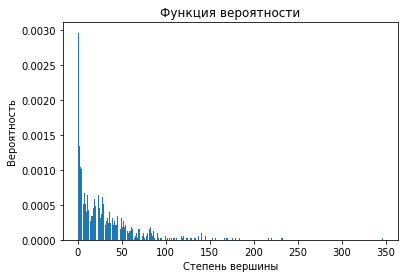

In [50]:
#sns.histplot(data=list(distribution.values()),bins=30)
plt.bar(distribution.keys(), distribution.values())
  
# naming the x axis
plt.xlabel('Степень вершины')
# naming the y axis
plt.ylabel('Вероятность')
# giving a title to my graph
plt.title('Функция вероятности')
  
# function to show the plot
plt.show()

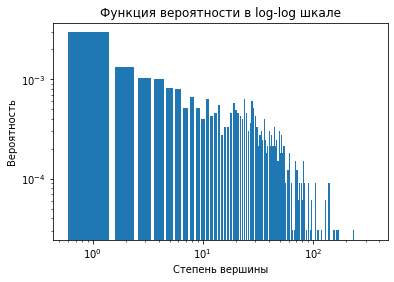

In [51]:
#sns.histplot(distribution,log_scale=True)
plt.bar(distribution.keys(), distribution.values())
  
# naming the x axis
plt.xlabel('Степень вершины')
# naming the y axis
plt.ylabel('Вероятность')
plt.xscale('log')
plt.yscale('log')  
# giving a title to my graph
plt.title('Функция вероятности в log-log шкале')
  
# function to show the plot
plt.show()